In [1]:
from src.torch_erg import load_pglib_opf as lp
from src.torch_erg.utils import laplacian_matrix
from src.torch_erg.samplers import GWGSampler, MHSampler
import torch
import numpy as np
import networkx as nx
import random as rnd

from scipy.sparse.csgraph import connected_components
from scipy.sparse import csr_matrix
# parsing the .m file into a suitable format, and perform some sanity checks
import matplotlib.pyplot as plt

from plots import *
from graph_generators import *
from param_estimation import *
from other_g_stats import *

In [2]:
name = '30_ieee'
SOFT_CONN = True

ordmat, ordlist, buslist, countlist = lp.pow_parser(name)

ordmat = torch.tensor(ordmat)
ordlist = torch.tensor(ordlist)
buslist = torch.tensor(buslist)
countlist = torch.tensor(countlist)

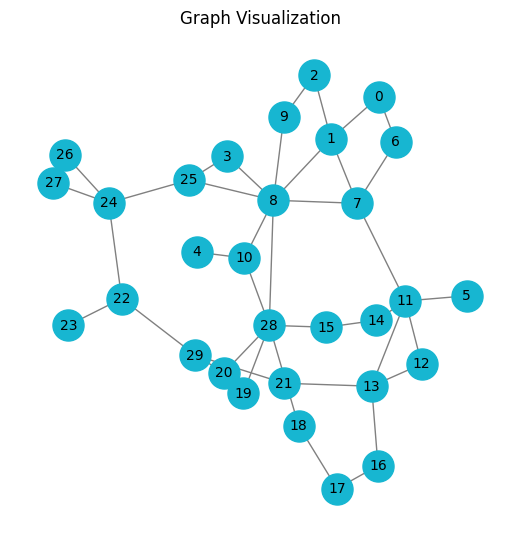

In [3]:
plot_graph(ordmat, labels=True)

In [21]:
alpha = 0.001
niter = 200000
min_change = 0.05
update_steps = 3

niter_sampling = 100000


In [23]:
class MySamplerFiveStats(MHSampler):
    def __init__(self, backend: str):
        super().__init__(backend)

    def observables(self,mtx):
        edges = torch.sum(mtx)/2
        triangles = torch.trace(torch.matmul(torch.matmul(mtx,mtx),mtx))/6
        ac = torch.linalg.eigvalsh(laplacian_matrix(mtx))[1]
        avg_degree = torch.sum(mtx, dim=1).mean()
        avg_clustering = avg_clustering_coeff(mtx)

        return(torch.stack([edges, triangles, ac, avg_degree, avg_clustering]))

betas = torch.tensor([0., 0., 0., 0., 0.], dtype=float)


sampler_five_stats = MySamplerFiveStats(backend="cuda")
obs_five_stats = sampler_five_stats.observables(ordmat)

params_five_stats, graphs_five_stats = sampler_five_stats.param_run(graph=ordmat,
                      observables=obs_five_stats,
                      params=betas,
                      niter=niter,
                      params_update_every=update_steps,
                      save_every=50,
                      save_params=True,
                      alpha=alpha,                      
                      min_change=min_change)

100%|██████████| 200000/200000 [13:35<00:00, 245.40it/s]

number of accepted steps is:  46233
number of rejected samples:  153767
number of effective updates is:  15411


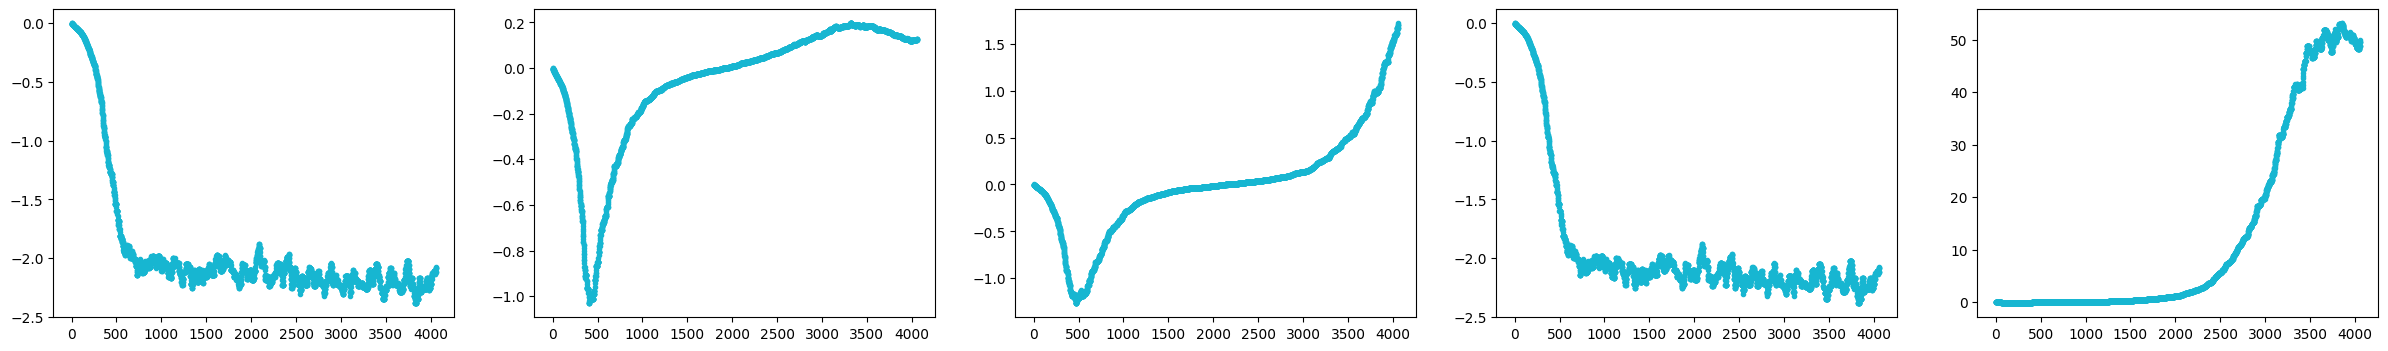

In [24]:
plot_params_iterations(params_five_stats)

In [25]:

params_for_estimates = torch.stack(params_five_stats[-100:]).mean(axis = 0)

observables_five_stats, graphs_five_stats = sampler_five_stats.sample_run(graph=ordmat,
                      observables=obs_five_stats,
                      params=params_for_estimates,
                      niter=niter_sampling,
                      save_every=50)

100%|██████████| 100000/100000 [06:34<00:00, 253.55it/s]

number of accepted steps is:  18167
number of rejected samples:  81833
Mean obs:  tensor([4.0529e+01, 7.3621e+00, 3.1893e-02, 2.7019e+00, 1.3420e-01],
       device='cuda:0', dtype=torch.float64)


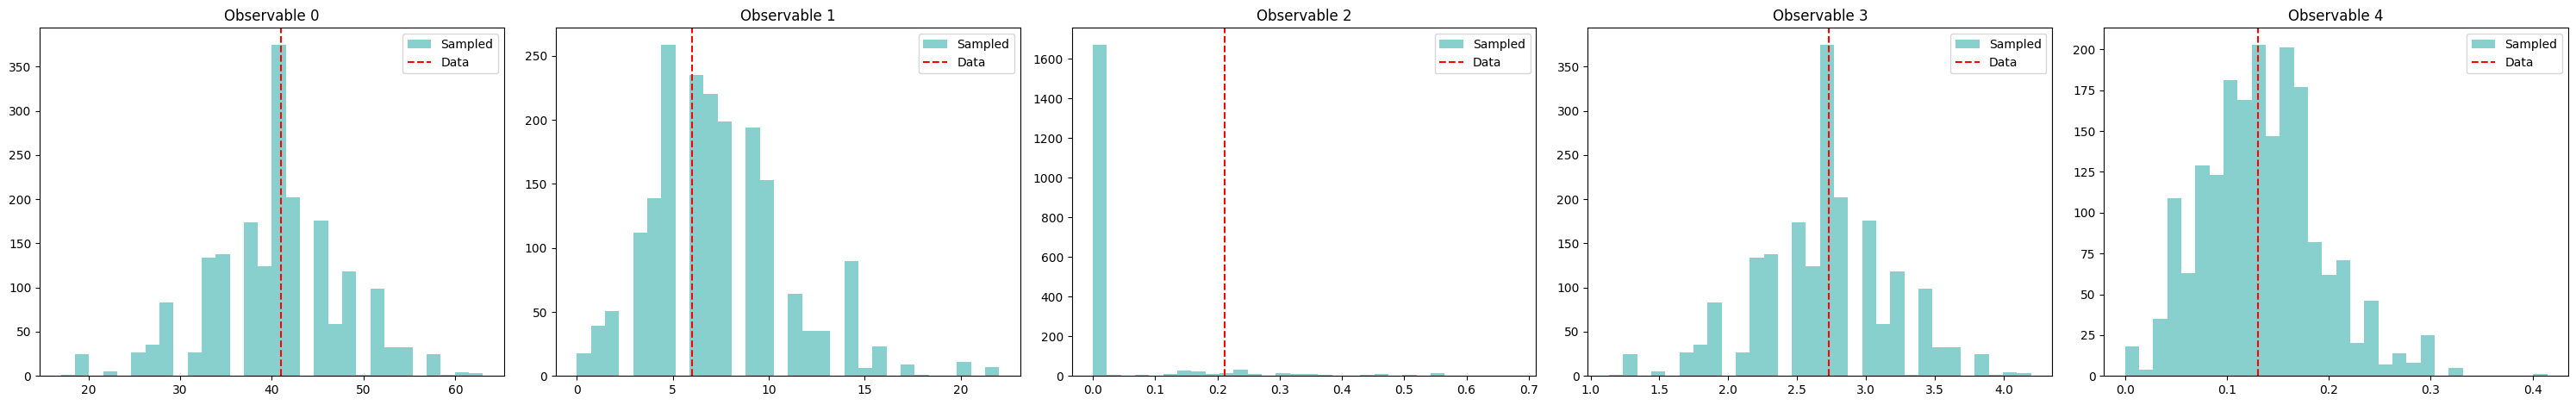

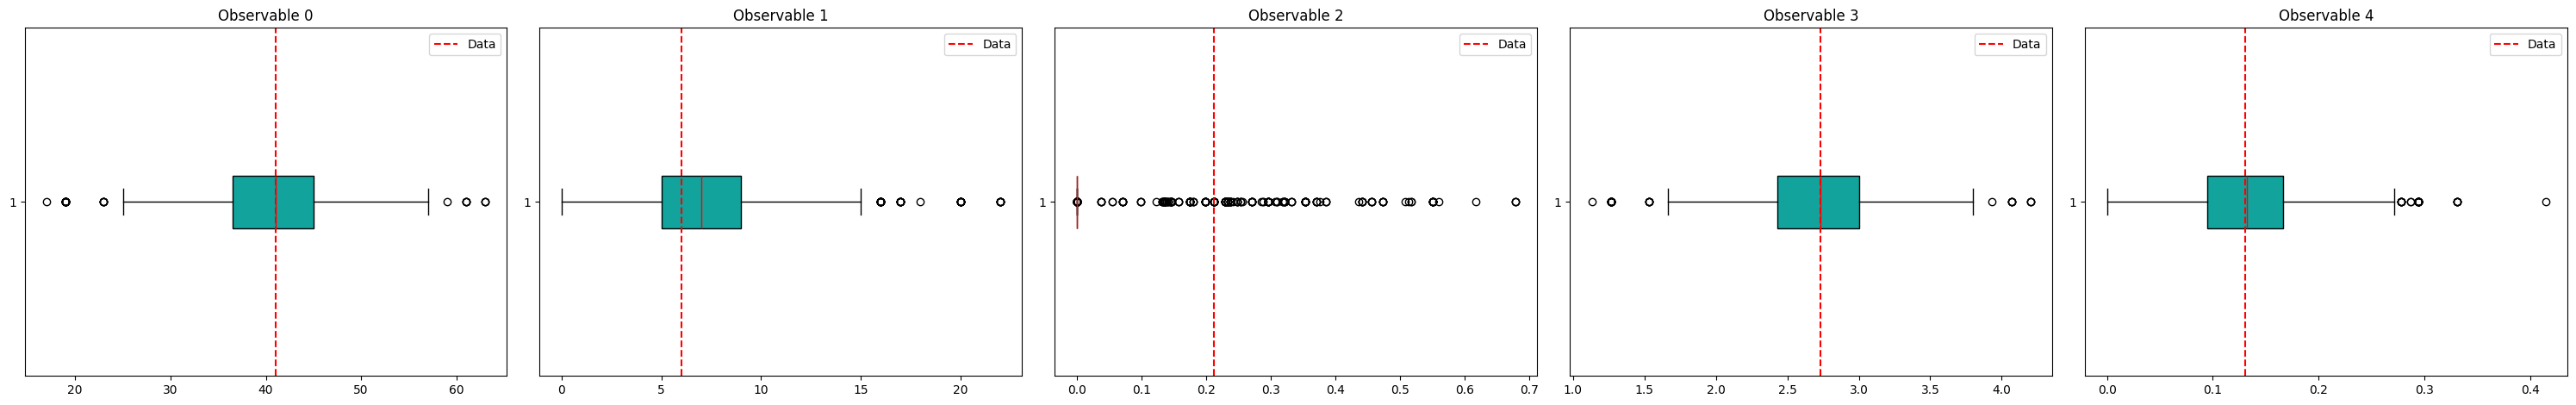

In [ ]:
hist_obs_samples(observables_five_stats, obs_five_stats)
boxplot_obs_samples(observables_five_stats, obs_five_stats)

In [34]:
connected_graphs_five_stats = [g for g in graphs_five_stats if connected_components(csr_matrix(g.cpu().numpy()))[0] <= 2]
connected_observables_five_stats = [sampler_five_stats.observables(g) for g in connected_graphs_five_stats]
len(connected_graphs_five_stats)

456

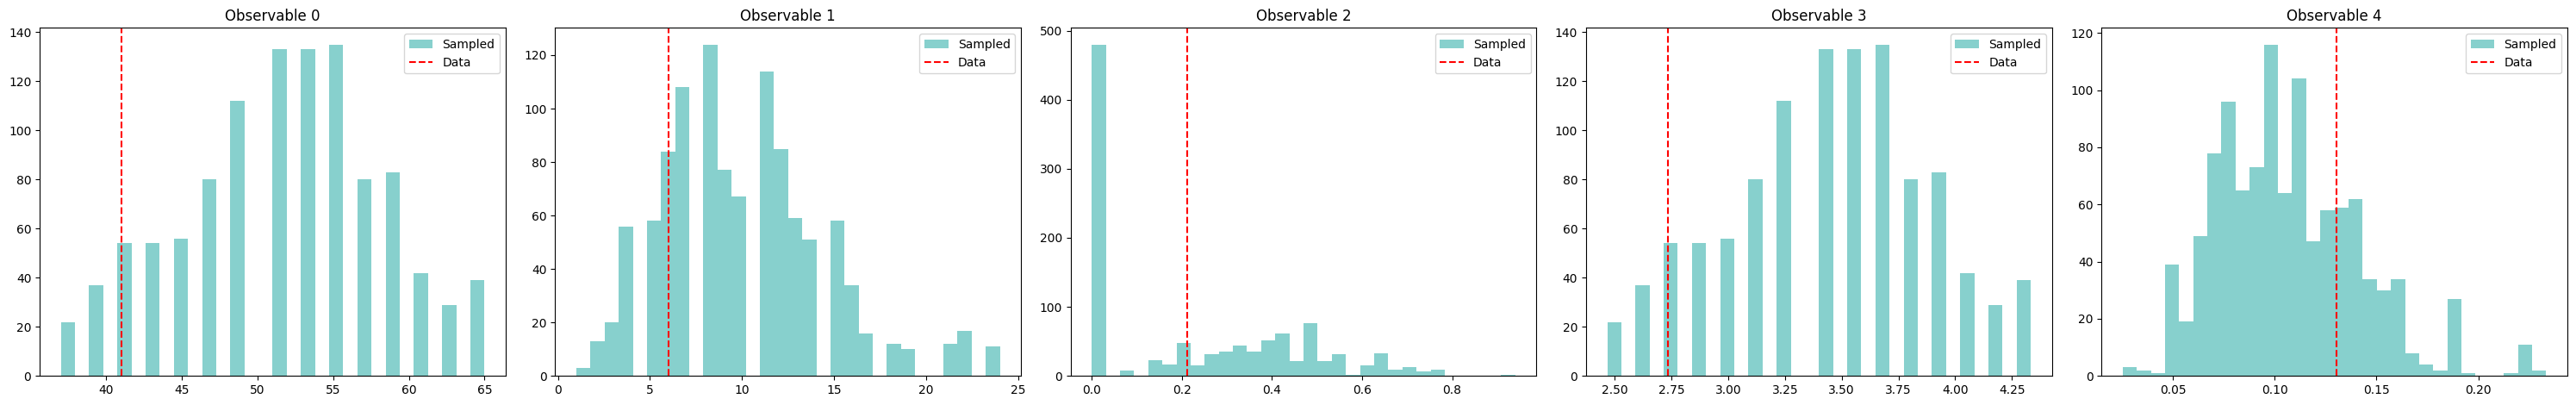

In [ ]:
hist_obs_samples(connected_observables_five_stats, obs_five_stats)

In [ ]:
class MySamplerNoAC(MHSampler):
    def __init__(self, backend: str):
        super().__init__(backend)
    def observables(self,mtx):
        edges = torch.sum(mtx)/2
        triangles = torch.trace(torch.matmul(torch.matmul(mtx,mtx),mtx))/6
        avg_degree = torch.sum(mtx, dim=1).mean()
        avg_clustering = avg_clustering_coeff(mtx)

        return(torch.stack([edges, triangles, avg_degree, avg_clustering]))
    
betas = torch.tensor([0., 0., 0., 0.], dtype=float)
sampler_no_ac = MySamplerNoAC(backend="cuda")
obs_no_ac = sampler_no_ac.observables(ordmat)
params_no_ac, graphs_no_ac = sampler_no_ac.param_run(graph=ordmat,
                      observables=obs_no_ac,
                      params=betas,
                      niter=niter,
                      params_update_every=update_steps,
                      save_every=50,
                      save_params=True,
                      alpha=alpha,                      
                      min_change=min_change)

100%|██████████| 200000/200000 [10:08<00:00, 328.54it/s]

number of accepted steps is:  47015
number of rejected samples:  152985
number of effective updates is:  15671


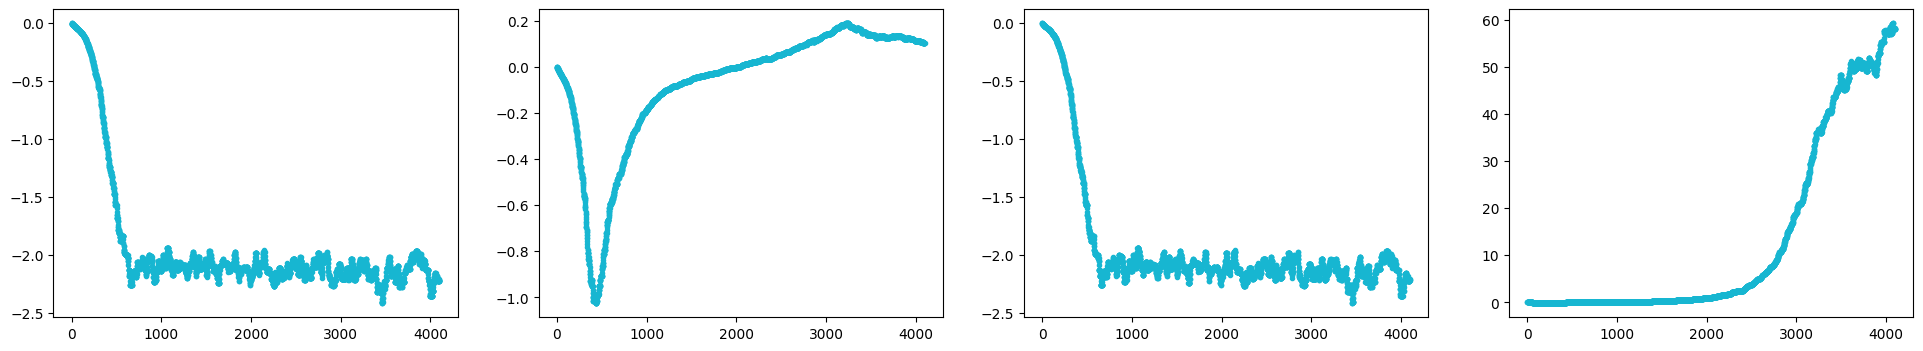

In [30]:
plot_params_iterations(params_no_ac)

In [31]:
params_for_estimates = torch.stack(params_no_ac[-100:]).mean(axis = 0)
# run in sample mode, without parameter modifications
observables_no_ac, graphs_no_ac = sampler_no_ac.sample_run(graph=ordmat,
                      observables=obs_no_ac,
                      params=params_for_estimates,
                      niter=niter_sampling,
                      save_every=50)

  0%|          | 0/100000 [00:00<?, ?it/s]

100%|██████████| 100000/100000 [04:36<00:00, 361.14it/s]

number of accepted steps is:  13626
number of rejected samples:  86374
Mean obs:  tensor([32.5971,  5.7861,  2.1731,  0.2006], device='cuda:0',
       dtype=torch.float64)


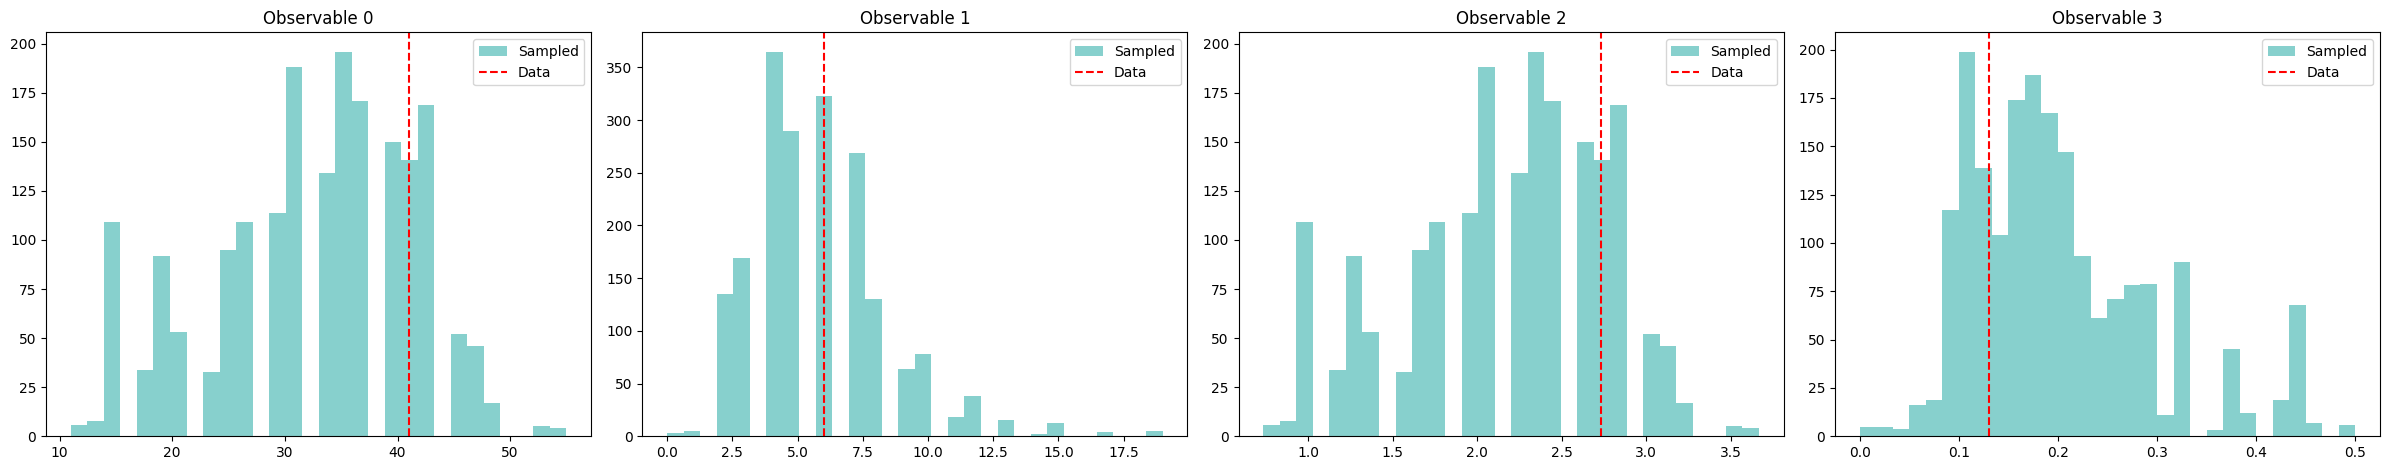

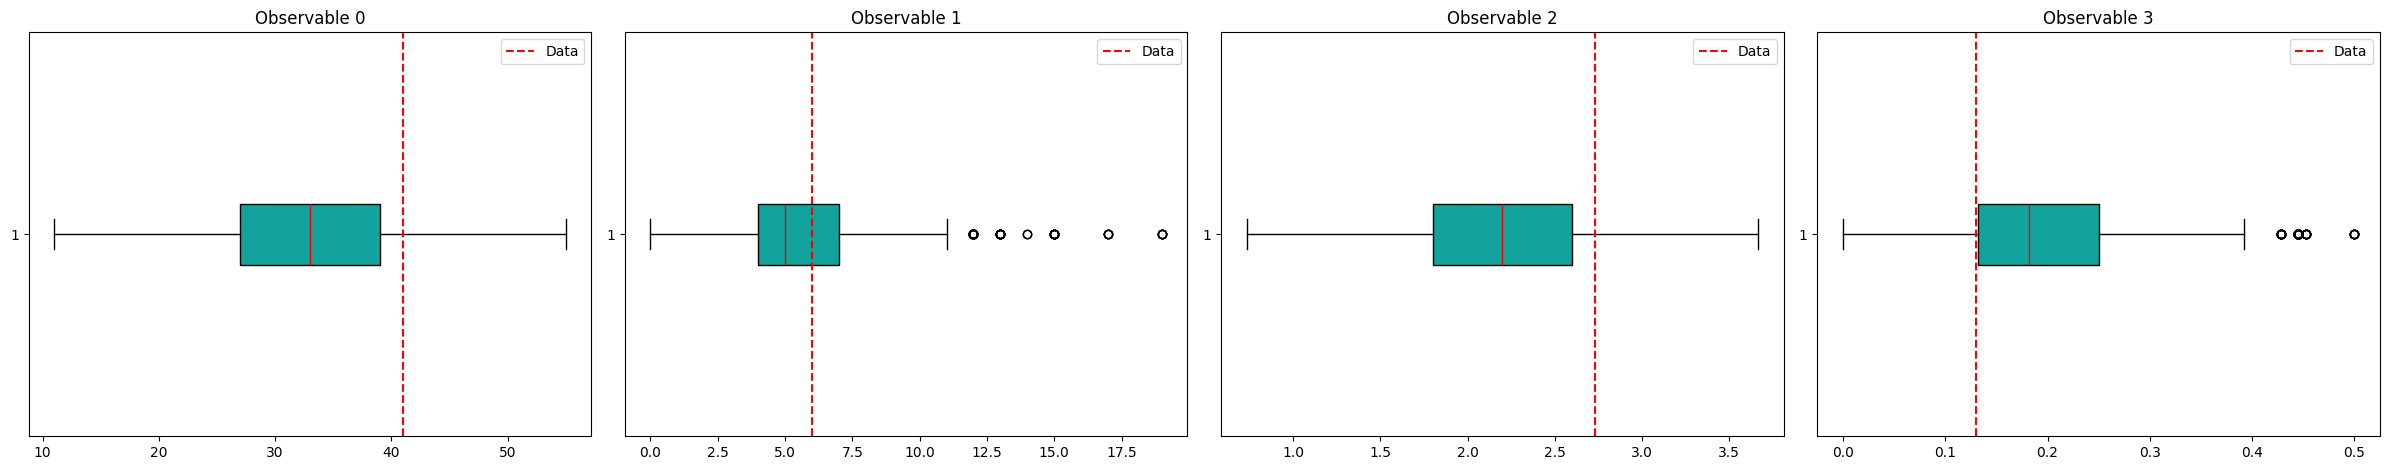

In [32]:
hist_obs_samples(observables_no_ac, obs_no_ac)
boxplot_obs_samples(observables_no_ac, obs_no_ac)

In [33]:
connected_graphs_no_ac = [g for g in graphs_no_ac if connected_components(csr_matrix(g.cpu().numpy()))[0] <= 2]
connected_observables_no_ac = [sampler_no_ac.observables(g) for g in connected_graphs_no_ac]
len(connected_graphs_no_ac)

279

---

In [42]:
alpha = 0.001
niterGWG = 200000
min_change = 0.05
update_steps = 3

niter_samplingGWG = 100000

class GWGSampler(GWGSampler):
    def __init__(self, backend: str):
        super().__init__(backend)

    def observables(self,mtx):
        
        edges = torch.sum(mtx)/2
        triangles = torch.trace(torch.matmul(torch.matmul(mtx,mtx),mtx))/6
        ac = torch.linalg.eigvalsh(laplacian_matrix(mtx))[1]
        avg_degree = torch.sum(mtx, dim=1).mean()
        avg_clustering = avg_clustering_coeff(mtx)

        return(torch.stack([edges, triangles, ac, avg_degree, avg_clustering]))

betas = torch.tensor([0., 0., 0., 0., 0.], dtype=float)

samplerGWG = GWGSampler(backend="cpu")
obsGWG = samplerGWG.observables(ordmat)

paramsGWG, _ = samplerGWG.param_run(graph=ordmat,
                      observables=obsGWG,
                      params=betas,
                      niter=niterGWG,
                      params_update_every=update_steps,
                      save_every=50,
                      save_params=True,
                      alpha=alpha,                      
                      min_change=min_change)

100%|██████████| 200000/200000 [21:12<00:00, 157.15it/s]

number of accepted steps is:  71273
number of rejected samples:  128727
number of effective updates is:  23757


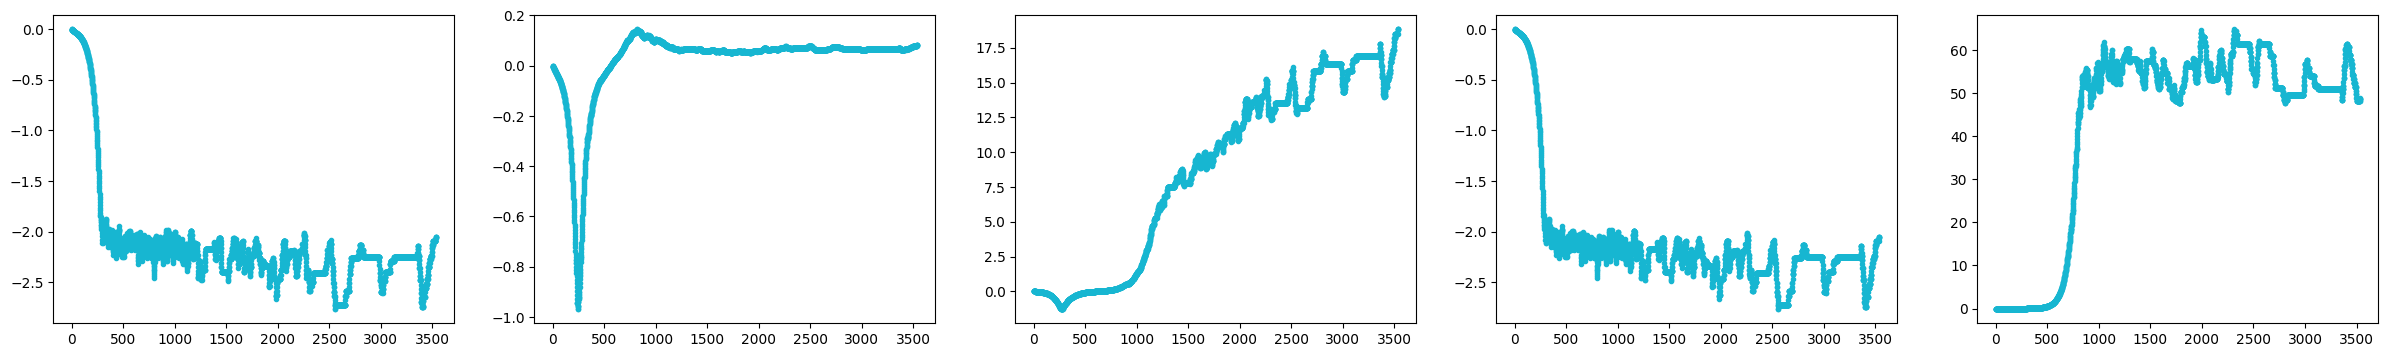

In [43]:
plot_params_iterations(paramsGWG)

In [44]:
params_for_estimates = torch.stack(paramsGWG[-100:]).mean(axis = 0)
# run in sample mode, without parameter modifications
observablesGWG, graphsGWG = samplerGWG.sample_run(graph=ordmat,
                      observables=obsGWG,
                      params=params_for_estimates,
                      niter=niter_sampling,
                      save_every=50)

100%|██████████| 100000/100000 [09:18<00:00, 178.94it/s]

number of accepted steps is:  21050
number of rejected samples:  78950
Mean obs:  tensor([72.6217, 17.9237,  1.3568,  4.8414,  0.0886], dtype=torch.float64)


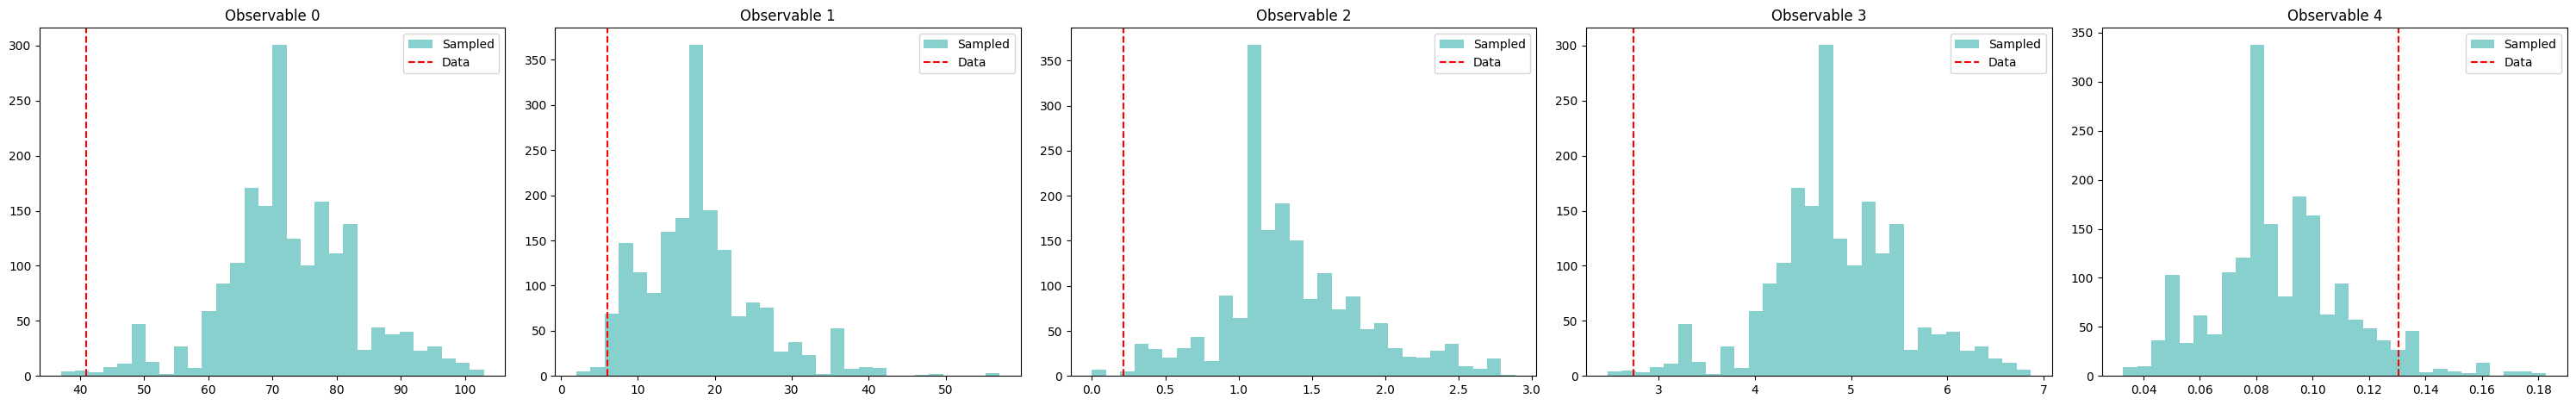

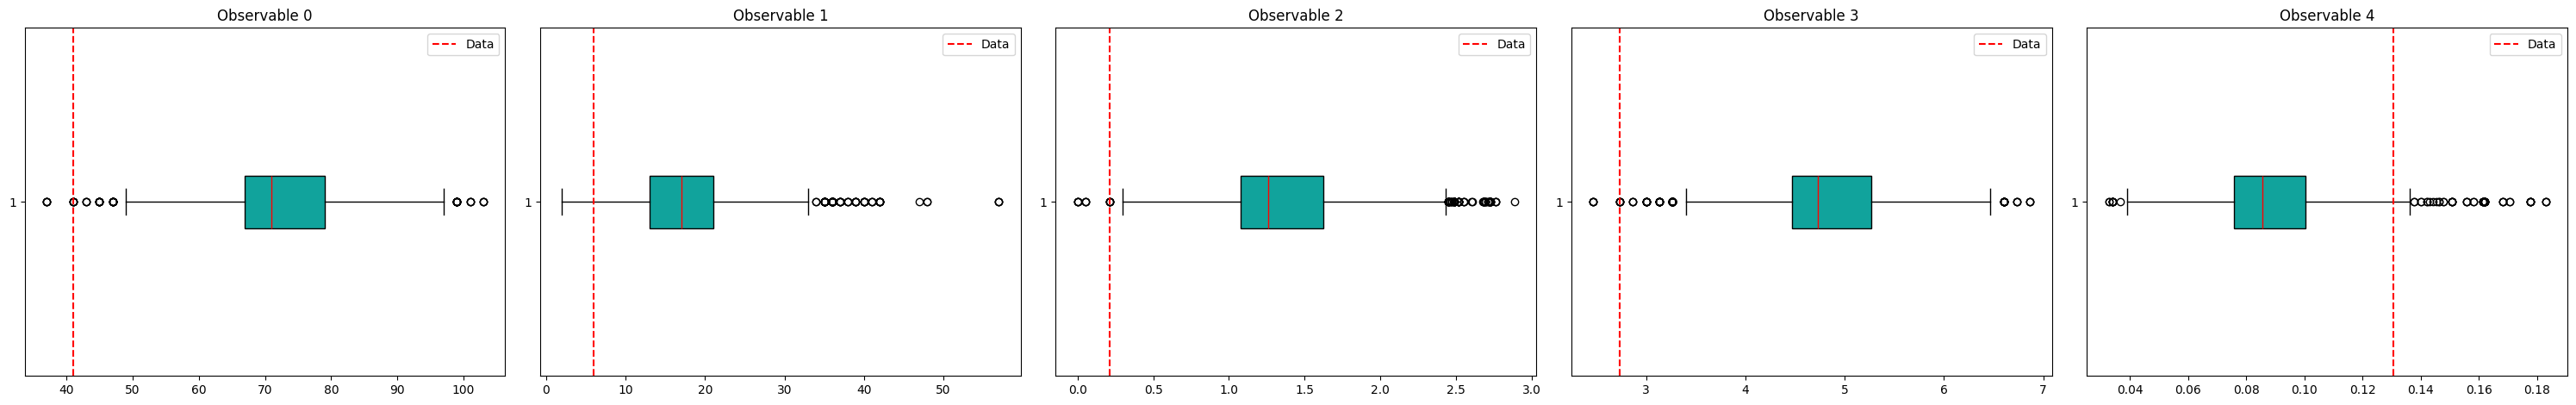

In [45]:
hist_obs_samples(observablesGWG, obsGWG)
boxplot_obs_samples(observablesGWG, obsGWG)

---

In [49]:

print(abs(obs_five_stats.cpu() - torch.stack(observables_five_stats).mean(axis = 0).cpu()))
print(abs(obs_no_ac.cpu() -torch.stack(observables_no_ac).mean(axis = 0).cpu()))
print(abs(obs_five_stats.cpu() - torch.stack(observablesGWG).mean(axis = 0).cpu()))

tensor([0.4711, 1.3621, 0.1802, 0.0314, 0.0038], dtype=torch.float64)
tensor([8.4029, 0.2139, 0.5602, 0.0702], dtype=torch.float64)
tensor([31.6217, 11.9237,  1.1447,  2.1081,  0.0419], dtype=torch.float64)
